#Labwork 5

In [1]:
import numpy as np
from numba import cuda, jit
from scipy.ndimage import gaussian_filter
from time import time
import matplotlib.pyplot as plt

In [2]:
# Load image
img = plt.imread('/content/wolf.jpg')

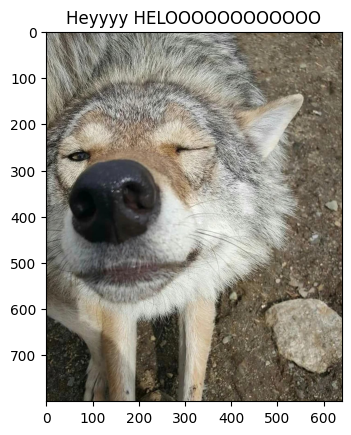

In [3]:
# Display the original image
plt.figure()
plt.imshow(img)
plt.title('Heyyyy HELOOOOOOOOOOOO')
plt.show()

In [4]:
def generate_gaussian_filter(sigma, filter_shape):
    m, n = filter_shape
    m_half = m // 2
    n_half = n // 2
    gaussian_filter = np.zeros((m, n), np.float32)
    for y in range(-m_half, m_half + 1):
        for x in range(-n_half, n_half + 1):
            normal = 1 / (2.0 * np.pi * sigma**2.0)
            exp_term = np.exp(-(x**2.0 + y**2.0) / (2.0 * sigma**2.0))
            gaussian_filter[y + m_half, x + n_half] = normal * exp_term
    return gaussian_filter / np.sum(gaussian_filter)

In [5]:
# Generate Gaussian filter
sigma = 5
filter_size = (7, 7)
gaussian_filter = generate_gaussian_filter(sigma, filter_size)

In [6]:
def gaussian_blur_cpu(image, kernel):
    if len(image.shape) == 3:
        m_i, n_i, c_i = image.shape
    elif len(image.shape) == 2:
        image = image[..., np.newaxis]
        m_i, n_i, c_i = image.shape
    else:
        raise Exception('Shape of image not supported')
    m_k, n_k = kernel.shape
    y_strides = m_i - m_k + 1
    x_strides = n_i - n_k + 1
    img = image.copy()
    output_shape = (m_i - m_k + 1, n_i - n_k + 1, c_i)
    output = np.zeros(output_shape, dtype=np.float32)
    count = 0
    output_tmp = output.reshape((output_shape[0] * output_shape[1], output_shape[2]))
    for i in range(y_strides):
        for j in range(x_strides):
            for c in range(c_i):
                sub_matrix = img[i:i + m_k, j:j + n_k, c]
                output_tmp[count, c] = np.sum(sub_matrix * kernel)
            count += 1
    output = output_tmp.reshape(output_shape)
    return output

In [7]:
# Gaussian blur on CPU
start_cpu = time()
blurred_img_cpu = gaussian_blur_cpu(img, gaussian_filter)
end_cpu = time()

print(f"CPU processing time: {end_cpu - start_cpu:.6f} seconds")

CPU processing time: 16.974832 seconds


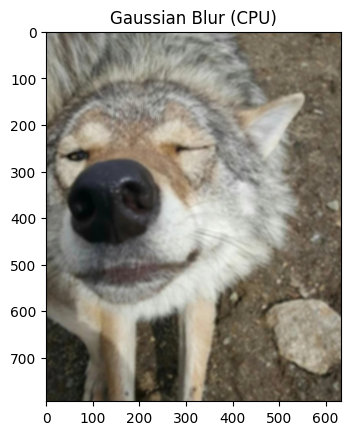

In [8]:
plt.imshow(blurred_img_cpu.astype(np.uint8))
plt.title('Gaussian Blur (CPU)')
plt.show()

In [9]:
@cuda.jit
def gaussian_blur_gpu(input_image, output_image, filter_device, image_height, image_width):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx >= image_width or tidy >= image_height:
        return

    filter_half = filter_device.shape[0] // 2
    weight = 0
    total_r, total_g, total_b = 0, 0, 0

    for j in range(-filter_half, filter_half + 1):
        for i in range(-filter_half, filter_half + 1):
            y = min(max(tidy + j, 0), image_height - 1)
            x = min(max(tidx + i, 0), image_width - 1)

            weight += filter_device[j + filter_half, i + filter_half]

            total_r += input_image[y, x, 0] * filter_device[j + filter_half, i + filter_half]
            total_g += input_image[y, x, 1] * filter_device[j + filter_half, i + filter_half]
            total_b += input_image[y, x, 2] * filter_device[j + filter_half, i + filter_half]

    if weight > 0:  # Avoid division by zero
        output_image[tidy, tidx, 0] = total_r / weight
        output_image[tidy, tidx, 1] = total_g / weight
        output_image[tidy, tidx, 2] = total_b / weight

In [10]:
@cuda.jit
def gaussian_blur_gpu_shared_memory(input_image, output_image, filter_device, image_height, image_width):
    tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if tidx >= image_width or tidy >= image_height:
        return

    # Allocate shared memory for the filter
    filter_size = filter_device.shape[0]
    cache = cuda.shared.array((7, 7), dtype=np.float32)

    # Load filter into shared memory
    if cuda.threadIdx.x < filter_size and cuda.threadIdx.y < filter_size:
        cache[cuda.threadIdx.y, cuda.threadIdx.x] = filter_device[cuda.threadIdx.y, cuda.threadIdx.x]

    cuda.syncthreads()

    # Initialize accumulators for RGB channels
    total_r, total_g, total_b = 0.0, 0.0, 0.0
    weight = 0.0

    # Apply the filter
    for j in range(-filter_size // 2, filter_size // 2 + 1):
        for i in range(-filter_size // 2, filter_size // 2 + 1):
            y = tidy + j
            x = tidx + i
            if 0 <= y < image_height and 0 <= x < image_width:
                weight += cache[j + filter_size // 2, i + filter_size // 2]
                total_r += input_image[y, x, 0] * cache[j + filter_size // 2, i + filter_size // 2]
                total_g += input_image[y, x, 1] * cache[j + filter_size // 2, i + filter_size // 2]
                total_b += input_image[y, x, 2] * cache[j + filter_size // 2, i + filter_size // 2]

    # Avoid division by zero and assign to output
    if weight > 0:
        output_image[tidy, tidx, 0] = total_r / weight
        output_image[tidy, tidx, 1] = total_g / weight
        output_image[tidy, tidx, 2] = total_b / weight

In [11]:
dev_input = cuda.to_device(img)
dev_output = cuda.device_array((img.shape[0], img.shape[1], img.shape[2]), dtype=np.float32)
filter_device = cuda.to_device(gaussian_filter)

In [12]:
blockSize = (16, 16)
gridSize = ((img.shape[1] + blockSize[0] - 1) // blockSize[0], (img.shape[0] + blockSize[1] - 1) // blockSize[1])

In [13]:
start_gpu = time()
gaussian_blur_gpu[gridSize, blockSize](dev_input, dev_output, filter_device, img.shape[0], img.shape[1])
cuda.synchronize()
end_gpu = time()

print(f"GPU processing time (without shared memory): {end_gpu - start_gpu:.6f} seconds")

GPU processing time (without shared memory): 0.427176 seconds


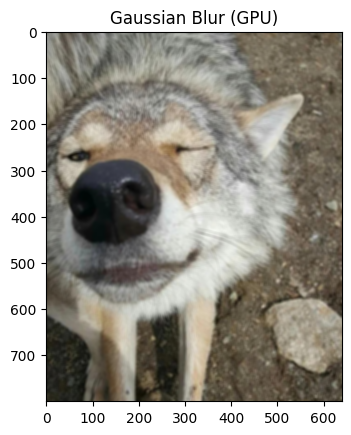

In [14]:
blurred_img_gpu = dev_output.copy_to_host()
plt.imshow(blurred_img_gpu.astype(np.uint8))
plt.title('Gaussian Blur (GPU)')
plt.show()

In [15]:
# Calculate speedup
speedup = (end_cpu - start_cpu) / (end_gpu - start_gpu)
print(f"Speedup: {speedup:.2f}x")

Speedup: 39.74x


In [16]:
# GPU Processing with shared memory
start_gpu_shared = time()
gaussian_blur_gpu_shared_memory[gridSize, blockSize](dev_input, dev_output, filter_device, filter_size[0], filter_size[1])
cuda.synchronize()
end_gpu_shared = time()

print(f"GPU processing time (with shared memory): {end_gpu_shared - start_gpu_shared:.6f} seconds")


GPU processing time (with shared memory): 0.353244 seconds


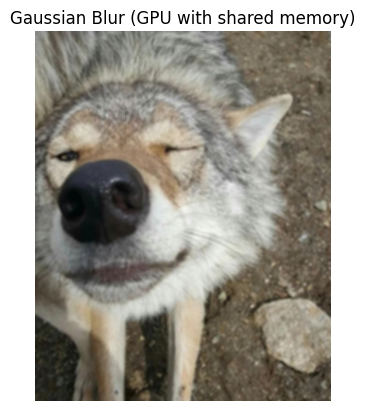

In [17]:
blurred_img_gpu_shared = dev_output.copy_to_host()
plt.imshow(blurred_img_gpu_shared.astype(np.uint8))
plt.title("Gaussian Blur (GPU with shared memory)")
plt.axis('off')
plt.show()

In [18]:
# Calculate speedup
speedup = (end_cpu - start_cpu) / (end_gpu_shared - start_gpu_shared)
print(f"Speedup: {speedup:.2f}x")

Speedup: 48.05x
